# Notebook 4 — Parameter Robustness

**Goal.** Check that the strategy’s edge is not a lucky setting.  
We’ll sweep parameters and compare **Profit Factor**, **Expectancy ($/trade)**, and **Max Drawdown**.

**Plan for this notebook**
- **4.1** Setup & helpers (reuse data, add a temporary override context).
- **4.2** **Entry time** sweep (10:00 → 10:30) + stability checks (year-by-year + Monte Carlo).
- (Next) **4.3** Zone cutoffs (top/bottom %) sweep.
- (Next) **4.4** SL/TP grid.

**Train/Test mindset (no ML):** Keep training sweeps for zones/SL-TP on **2020–2021** with **2022–2023** as hold-out, and add **full-window stress (2020–2024)** for entry-time timing.


## What to expect
- Audience: strategy/markets readers; we sweep parameters to see if results hold up around the baseline.
- Inputs: `valid_days.csv` (audited dates), configs in `config/*.yml`, and the core functions from Notebook 3 (`execute_day`).
- Outputs: sweep tables/plots for entry time plus Monte Carlo + yearly stability checks, saved to `reports/tables/`.
- Flow: set up → run entry-time sweep on **all 2020–2024 days** → stress with yearly splits + Monte Carlo resamples → pick candidates to re-test on 2022–2023.
- You do **not** edit parameters here permanently; use the sweep overrides and adjust YAML if you choose new defaults.


## Inputs & outputs
- **Inputs:**
  - `reports/tables/valid_days.csv` (2020–2024 audited dates; keep 2020–2021 vs. 2022–2023 split for other sweeps).
  - `data/raw/*.csv` minute data (already parsed by the core loader).
  - `execute_day` imported from `src/or_core` (built in Notebook 3).
- **Outputs (saved):**
  - `reports/tables/entry_time_sweep.csv` (PF, expectancy, max DD per entry time, 2020–2024 sweep).
  - `reports/tables/entry_time_yearly.csv` (PF/expectancy/DD per entry time per calendar year).
  - `reports/tables/entry_time_mc_summary.csv` (quantiles + probabilities from Monte Carlo resampling).
  - Figures (if you save them manually) for PF/expectancy/DD vs. entry time.
- **Next:** reuse the same pattern to sweep **zone cutoffs** and **SL/TP grids**, then re-run the best combos on the test years (2022–2023).


### 4.1 — Setup & helpers (what we’re doing here)

* **Purpose:** prepare the environment so later sections (4.2–4.4) can sweep parameters without noisy output.
* **What this cell sets up:**

  1. Paths to `reports/tables/` and loading **valid_days** (from memory if it exists, otherwise from `valid_days.csv`).
  2. Split the data into a **training window (2020–2021)** we’ll use for zone/SL-TP sweeps first, keep **2022–2023** aside for later confirmation, and also keep **2020–2024** handy for entry-time stress tests.
  3. A small set of **constants** (e.g., `POINT_VAL`, `init_capital`) with safe fallbacks.
  4. Two tiny **helpers**:

     * `mute_everything()` — silences prints/plots so sweeps don’t spam output.
     * `temporary_strategy_overrides(...)` — lets us *temporarily* tweak strategy params (entry time, zone %s, SL/TP) during a sweep without permanently changing your config.
     * `_execute_with_overrides(...)` — passes overrides into `execute_day` if it supports them; otherwise relies on the temporary config override.
* **No backtest loops run in this step.** We’re only preparing.
* **Quick sanity print** at the end shows how many training vs. test vs. full-window entry-time days we have (from `valid_days`).


In [ ]:
from pathlib import Path
import sys

# 1) Compute project ROOT (notebooks are now in notebooks/trading/)
if Path.cwd().name == "trading" and Path.cwd().parent.name == "notebooks":
    ROOT = Path.cwd().parent.parent  # notebooks/trading/ -> project root
elif Path.cwd().name == "notebooks":
    ROOT = Path.cwd().parent
else:
    ROOT = Path.cwd()

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))  # put project root on import path first

# 2) Quick diagnostics (helps catch typos/locations)
print("CWD:", Path.cwd())
print("ROOT:", ROOT)
print("services/trading exists:", (ROOT / "services" / "trading").exists())
print("or_core exists:", (ROOT / "services" / "trading" / "or_core.py").exists())

# 3) Import the core (module + function)
from services.trading import or_core              # module (lets us tweak or_core.ENTRY_T, etc.)
from services.trading.or_core import execute_day  # function

CWD: d:\Projects\OpeningRange\notebooks
ROOT: d:\Projects\OpeningRange
src exists: True
or_core exists: True


In [2]:
# 4.1 — Setup & helpers

from pathlib import Path
import pandas as pd
import numpy as np
import inspect
from contextlib import contextmanager

# --- Paths
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables" / "robustness"
AUDIT_TBLS = ROOT / "reports" / "tables" / "audit"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

# --- Load audited days (from Notebook 2) or CSV
try:
    valid_days
    vd = valid_days.copy()
except NameError:
    vd = pd.read_csv(AUDIT_TBLS / "valid_days.csv", parse_dates=["date"])

vd = vd.sort_values("date").reset_index(drop=True)
vd["year"] = vd["date"].dt.year

# --- Define train/test years (we’ll sweep on TRAIN first)
TRAIN_YEARS = {2020, 2021}
TEST_YEARS  = {2022, 2023}
ENTRY_YEARS = {2020, 2021, 2022, 2023, 2024}

vd_train = vd[vd["year"].isin(TRAIN_YEARS)].copy()
vd_test  = vd[vd["year"].isin(TEST_YEARS)].copy()
vd_entry = vd[vd["year"].isin(ENTRY_YEARS)].copy()

# --- Pull constants (safe fallbacks)
try:
    POINT_VAL = INSTR["market"]["point_value_usd"]
except Exception:
    POINT_VAL = 80.0

try:
    init_capital
except NameError:
    init_capital = 100_000.0

# --- Helper to silence prints/plots during sweeps
import io, IPython.display as ipd
from contextlib import redirect_stdout, redirect_stderr

@contextmanager
def mute_everything():
    buf_out, buf_err = io.StringIO(), io.StringIO()
    orig_ipd_display = ipd.display
    orig_global_display = globals().get("display", None)
    try:
        ipd.display = lambda *a, **k: None
        if orig_global_display is not None:
            globals()["display"] = lambda *a, **k: None
        with redirect_stdout(buf_out), redirect_stderr(buf_err):
            yield
    finally:
        ipd.display = orig_ipd_display
        if orig_global_display is not None:
            globals()["display"] = orig_global_display

# --- Temporary overrides for strategy params (non-destructive)
def _set_nested(d, path, value):
    cur = d
    for k in path[:-1]:
        if not isinstance(cur, dict) or k not in cur:
            return False
        cur = cur[k]
    if isinstance(cur, dict) and path[-1] in cur:
        cur[path[-1]] = value
        return True
    return False

@contextmanager
def temporary_strategy_overrides(entry_time=None, bot_pct=None, top_pct=None, sl_pts=None, tp_pts=None):
    '''
    Temporarily modify STRATEGY dict for sweeps. If STRATEGY isn't present,
    we’ll pass overrides directly to execute_day (next helper).
    '''
    backup = None
    try:
        if "STRATEGY" in globals() and isinstance(STRATEGY, dict):
            import copy
            backup = copy.deepcopy(STRATEGY)
            if entry_time is not None:
                _set_nested(STRATEGY, ["rules","entry","time"], entry_time)
            if bot_pct is not None:
                _set_nested(STRATEGY, ["rules","zones","bottom_pct"], float(bot_pct))
            if top_pct is not None:
                _set_nested(STRATEGY, ["rules","zones","top_pct"], float(top_pct))
            if sl_pts is not None:
                _set_nested(STRATEGY, ["rules","risk","sl_points"], int(sl_pts))
            if tp_pts is not None:
                _set_nested(STRATEGY, ["rules","risk","tp_points"], int(tp_pts))
        yield
    finally:
        if backup is not None:
            STRATEGY.clear()
            STRATEGY.update(backup)

def _execute_with_overrides(date_str, **overrides):
    '''
    Call execute_day with overrides if it accepts them; otherwise rely on
    temporary_strategy_overrides having already set STRATEGY.
    '''
    sig = inspect.signature(execute_day)
    kwargs = {}
    for k in ["entry_time", "bot_pct", "top_pct", "sl_pts", "tp_pts", "overrides"]:
        if k in sig.parameters and overrides.get(k) is not None:
            kwargs[k] = overrides[k]
    return execute_day(date_str, **kwargs)

# --- Minimal sanity print
print(f"Training window days (2020–2021): {len(vd_train)}")
print(f"Test window days     (2022–2023): {len(vd_test)}")
print(f"Entry window days    (2020–2024): {len(vd_entry)}")
print(f"Point value used: ${POINT_VAL:.2f} per point | Initial capital: ${init_capital:,.0f}")


Training window days (2020–2021): 510
Test window days     (2022–2023): 392
Entry window days    (2020–2024): 1156
Point value used: $80.00 per point | Initial capital: $100,000


### 4.2 — Entry-time sweep (all 2020–2024 days)

**Why:** Entry timing can change signal quality a lot; we want to see whether performance is stable around 10:22.
**What we vary:** the **entry time** only → `10:00, 10:05, 10:10, 10:15, 10:20, 10:22, 10:25, 10:30`.
**What we hold fixed:** zones = **top/bottom 35%**, **SL = 25 pts**, **TP = 75 pts** (your baseline).
**Metrics we report:**

* **Profit Factor** (sum of wins ÷ |sum of losses|) on trade days only
* **Expectancy ($/trade)** (average P&L per executed trade)
* **Max Drawdown (USD)** from the equity built on those days
  **Scope:** All audited days (**2020–2024**), **gross** P&L (no costs) for a clean *relative* comparison.
  **Extras:** year-by-year stability + Monte Carlo resampling to prefer times that survive different day mixes.


d:\Projects\OpeningRange\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Entry-time sweep (2020–2024): 100%|██████████| 8/8 [00:45<00:00,  5.72s/it]


,entry_time,trades,pf,exp_usd,max_dd
0,10:00,870,1.091723,122.340506,61115.20
1,10:05,884,1.089191,119.095023,104946.40
2,10:10,897,1.279039,351.790412,46870.56
3,10:15,924,1.117061,153.870823,79864.64
4,10:20,947,1.164540,211.592988,50290.40
5,10:22,954,1.331514,404.457023,43808.48
6,10:25,964,1.257773,320.359004,54827.68
7,10:30,971,1.281213,340.856272,38128.16


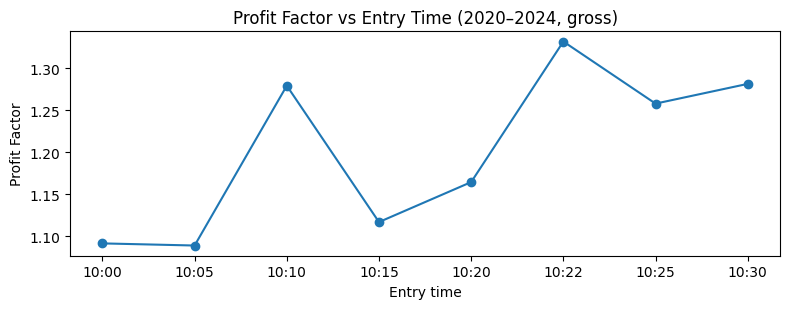

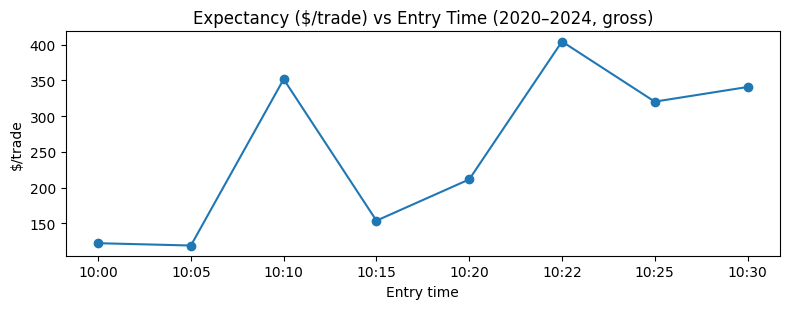

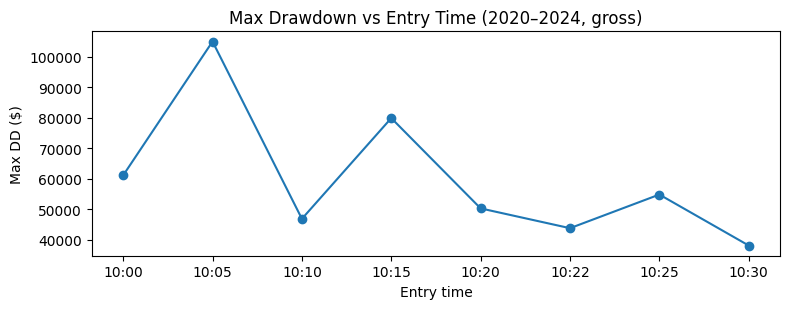

In [3]:
# 4.2 — Entry-time sweep (all 2020–2024 days)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
from src import or_core
from src.or_core import execute_day

# --- safety: require execute_day from Notebook 3
if "execute_day" not in globals():
    raise RuntimeError("Missing `execute_day`. Please run Notebook 3 (sections 3.2–3.5) first.")

# --- helper to call execute_day with overrides if supported
def _execute_with_overrides(date_str, **overrides):
    sig = inspect.signature(execute_day)
    kwargs = {}
    for k in ["entry_time", "bot_pct", "top_pct", "sl_pts", "tp_pts", "overrides"]:
        if k in sig.parameters and overrides.get(k) is not None:
            kwargs[k] = overrides[k]
    return execute_day(date_str, **kwargs)

# --- metric helper reused by sweeps/Monte Carlo
def compute_metrics(df):
    df = df.sort_values("date").reset_index(drop=True)
    df["pnl_usd_filled"] = df["pnl_usd"].fillna(0.0)

    is_trade = df["decision"].isin(["long","short"])
    trades   = df[is_trade]
    wins     = trades["pnl_usd"] > 0
    losses   = trades["pnl_usd"] < 0
    sum_w = trades.loc[wins,  "pnl_usd"].sum()
    sum_l = -trades.loc[losses, "pnl_usd"].sum()
    pf = (sum_w / sum_l) if sum_l > 0 else np.nan
    exp_usd = trades["pnl_usd"].mean() if len(trades) else np.nan

    eq = init_capital + df["pnl_usd_filled"].cumsum()
    dd = (eq.cummax() - eq).astype(float)
    max_dd = float(dd.max()) if len(dd) else np.nan

    return {"trades": int(is_trade.sum()), "pf": float(pf), "exp_usd": float(exp_usd), "max_dd": max_dd}

# --- one run for a given entry time (zones/sl/tp fixed)
def run_backtest_for_params(dates, entry_time, bot_pct=0.35, top_pct=0.35, sl_pts=25, tp_pts=75, return_daily=False):
    records = []
    # temporarily override config if STRATEGY dict exists; otherwise pass via kwargs
    with temporary_strategy_overrides(entry_time=entry_time, bot_pct=bot_pct, top_pct=top_pct,
                                      sl_pts=sl_pts, tp_pts=tp_pts):
        for d in dates:
            with mute_everything():
                ex = _execute_with_overrides(d, entry_time=entry_time, bot_pct=bot_pct,
                                             top_pct=top_pct, sl_pts=sl_pts, tp_pts=tp_pts)
            records.append({"date": d, "decision": ex.decision, "pnl_usd": ex.pnl_usd})
    df = pd.DataFrame.from_records(records)
    metrics = compute_metrics(df)
    if return_daily:
        daily = df[["date","decision","pnl_usd"]].copy()
        daily["pnl_usd_filled"] = daily["pnl_usd"].fillna(0.0)
        return metrics, daily
    return metrics

# --- run the sweep on all entry dates
ENTRY_GRID = ["10:00","10:05","10:10","10:15","10:20","10:22","10:25","10:30"]
dates_entry = vd_entry["date"].dt.strftime("%Y-%m-%d").tolist()

daily_by_entry = {}
rows = []
for et in tqdm(ENTRY_GRID, desc="Entry-time sweep (2020–2024)"):
    or_core.ENTRY_T = et
    k, daily = run_backtest_for_params(dates_entry, entry_time=et, bot_pct=0.35, top_pct=0.35, sl_pts=25, tp_pts=75, return_daily=True)
    k["entry_time"] = et
    rows.append(k)
    daily_by_entry[et] = daily

sweep_et = pd.DataFrame(rows).sort_values("entry_time").reset_index(drop=True)
display(sweep_et[["entry_time","trades","pf","exp_usd","max_dd"]])

# --- small visuals
plt.figure(figsize=(8,3.2))
plt.plot(sweep_et["entry_time"], sweep_et["pf"], marker="o")
plt.title("Profit Factor vs Entry Time (2020–2024, gross)")
plt.xlabel("Entry time"); plt.ylabel("Profit Factor")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3.2))
plt.plot(sweep_et["entry_time"], sweep_et["exp_usd"], marker="o")
plt.title("Expectancy ($/trade) vs Entry Time (2020–2024, gross)")
plt.xlabel("Entry time"); plt.ylabel("$/trade")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3.2))
plt.plot(sweep_et["entry_time"], sweep_et["max_dd"], marker="o")
plt.title("Max Drawdown vs Entry Time (2020–2024, gross)")
plt.xlabel("Entry time"); plt.ylabel("Max DD ($)")
plt.tight_layout(); plt.show()


### 4.2B — Year-by-year stability (2020–2024)
- **Goal:** avoid picking entry times that only work in a single year.
- **Method:** reuse the day-level results from 4.2, regroup by calendar year, and recompute PF/Expectancy/Max DD per entry time.


In [4]:
# 4.2B — Year-by-year stability (2020–2024)
import pandas as pd

if "daily_by_entry" not in globals():
    raise RuntimeError("Run 4.2 to build daily_by_entry before checking yearly stability.")

yearly_rows = []
for et, df_daily in daily_by_entry.items():
    df_year = df_daily.copy()
    df_year["year"] = pd.to_datetime(df_year["date"]).dt.year
    for year, grp in df_year.groupby("year"):
        m = compute_metrics(grp)
        m.update({"entry_time": et, "year": int(year)})
        yearly_rows.append(m)

sweep_et_yearly = pd.DataFrame(yearly_rows).sort_values(["entry_time","year"]).reset_index(drop=True)
display(sweep_et_yearly[["entry_time","year","trades","pf","exp_usd","max_dd"]])


,entry_time,year,trades,pf,exp_usd,max_dd
0,10:00,2020,188,1.029037,36.559574,36575.20
1,10:00,2021,191,1.345251,429.417382,40554.56
2,10:00,2022,200,1.075926,107.520000,54892.00
3,10:00,2023,106,0.954395,-63.675472,36619.20
4,10:00,2024,185,1.010944,15.080649,42278.08
5,10:05,2020,196,1.024760,31.841633,26048.80
6,10:05,2021,189,1.346297,420.203175,45742.40
7,10:05,2022,195,1.121153,167.508923,60755.20
8,10:05,2023,106,0.718152,-420.113208,50833.60
9,10:05,2024,198,1.116033,159.032323,28409.84


### 4.2C — Monte Carlo resampling (2020–2024 days)
- **Goal:** test how each entry time holds up when the day mix changes.
- **Method:** sample 70% of 2020–2024 days *with replacement* for 400 runs per entry time; record PF/Expectancy/DD; rank by medians + downside quantiles.
- **Why it helps:** favors times that are less sensitive to which days land in the sample (drawdown and PF remain acceptable in most resamples).


,entry_time,pf_p05,pf_median,pf_p95,exp_p05,exp_median,exp_p95,prob_pf_gt1,prob_exp_gt0
0,10:22,1.145036,1.325545,1.544009,186.097899,397.416554,636.126766,0.9975,0.9975
1,10:10,1.098887,1.285364,1.477587,132.039179,356.383882,573.297331,0.9950,0.9950
2,10:30,1.097557,1.280088,1.474079,122.736412,338.457260,554.619998,0.9950,0.9950
3,10:25,1.086294,1.260399,1.452033,113.043626,322.004684,536.139901,0.9975,0.9975
4,10:20,1.002222,1.160345,1.338511,2.994396,207.190225,415.723309,0.9500,0.9500
5,10:15,0.958935,1.116433,1.286158,-57.327846,152.768068,358.677184,0.9075,0.9075
6,10:00,0.928508,1.087228,1.256665,-99.024225,115.427151,328.837617,0.7875,0.7875
7,10:05,0.926934,1.083236,1.277313,-102.707313,111.475310,355.375619,0.7975,0.7975


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_19516\3229907001.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mc_results[et]["pf"].dropna() for et in order], labels=order, showfliers=False)


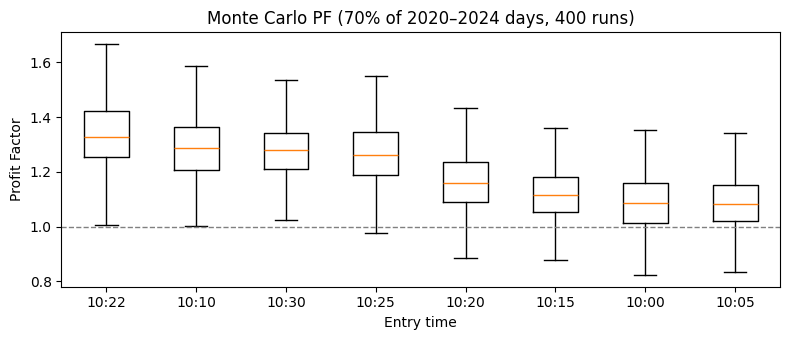

In [5]:
# 4.2C — Monte Carlo resampling (2020–2024 days)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def monte_carlo_metrics(daily_df, n_iter=400, sample_frac=0.7, seed=7):
    rng = np.random.default_rng(seed)
    n = len(daily_df)
    sample_size = max(1, int(n * sample_frac))
    runs = []
    for i in range(n_iter):
        idx = rng.choice(n, size=sample_size, replace=True)
        sample = daily_df.iloc[idx]
        m = compute_metrics(sample)
        m.update({"iter": i})
        runs.append(m)
    return pd.DataFrame(runs)

def _safe_q(series, q):
    ser = series.dropna()
    return float(ser.quantile(q)) if len(ser) else np.nan

mc_results = {}
mc_summary_rows = []
for et, df_daily in daily_by_entry.items():
    res = monte_carlo_metrics(df_daily, n_iter=400, sample_frac=0.7, seed=7)
    mc_results[et] = res
    mc_summary_rows.append({
        "entry_time": et,
        "pf_p05": _safe_q(res["pf"], 0.05),
        "pf_median": _safe_q(res["pf"], 0.50),
        "pf_p95": _safe_q(res["pf"], 0.95),
        "exp_p05": _safe_q(res["exp_usd"], 0.05),
        "exp_median": _safe_q(res["exp_usd"], 0.50),
        "exp_p95": _safe_q(res["exp_usd"], 0.95),
        "prob_pf_gt1": float((res["pf"] > 1.0).mean()),
        "prob_exp_gt0": float((res["exp_usd"] > 0.0).mean()),
    })

mc_summary = pd.DataFrame(mc_summary_rows).sort_values("pf_median", ascending=False).reset_index(drop=True)
display(mc_summary[["entry_time","pf_p05","pf_median","pf_p95","exp_p05","exp_median","exp_p95","prob_pf_gt1","prob_exp_gt0"]])

# quick visual: PF distribution per entry time
plt.figure(figsize=(8,3.5))
order = list(mc_summary["entry_time"])
plt.boxplot([mc_results[et]["pf"].dropna() for et in order], labels=order, showfliers=False)
plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
plt.title("Monte Carlo PF (70% of 2020–2024 days, 400 runs)")
plt.xlabel("Entry time"); plt.ylabel("Profit Factor")
plt.tight_layout(); plt.show()


In [6]:
# 4.2A — Save sweep results & highlight candidates
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables" / "robustness"
AUDIT_TBLS = ROOT / "reports" / "tables" / "audit"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

try:
    sweep_et
except NameError:
    print("Run 4.2 first to build sweep_et.")
else:
    out_path = REPORTS_TBLS / "entry_time_sweep.csv"
    sweep_et.to_csv(out_path, index=False)
    print("Saved entry-time sweep ->", out_path)

    if "sweep_et_yearly" in globals():
        out_year = REPORTS_TBLS / "entry_time_yearly.csv"
        sweep_et_yearly.to_csv(out_year, index=False)
        print("Saved entry-time yearly stability ->", out_year)

    if "mc_summary" in globals():
        out_mc = REPORTS_TBLS / "entry_time_mc_summary.csv"
        mc_summary.to_csv(out_mc, index=False)
        print("Saved entry-time Monte Carlo summary ->", out_mc)

    # Highlight by Profit Factor and Expectancy (full window)
    pf_sorted = sweep_et.sort_values("pf", ascending=False)
    exp_sorted = sweep_et.sort_values("exp_usd", ascending=False)
    print("\nTop 3 by Profit Factor (2020–2024 sweep):")
    display(pf_sorted.head(3)[["entry_time","trades","pf","exp_usd","max_dd"]])
    print("\nTop 3 by Expectancy ($/trade):")
    display(exp_sorted.head(3)[["entry_time","trades","pf","exp_usd","max_dd"]])

    if "mc_summary" in globals():
        print("\nTop 3 Monte Carlo (median PF):")
        display(mc_summary.head(3)[["entry_time","pf_p05","pf_median","pf_p95","prob_pf_gt1","prob_exp_gt0"]])


SyntaxError: unterminated string literal (detected at line 32) (813945986.py, line 32)

## Quick read (fill after running)
- Best entry times by Profit Factor (2020–2024 sweep): ____; by Expectancy: ____.
- Year-by-year stability: ____ holds PF > 1.0 in >= __ of 5 years; weakest year for the top pick: ____.
- Monte Carlo (70% day resamples, 400 runs): ____ has the best median PF; PF > 1.0 in __% of runs; downside PF (5th pct) = ____.
- Candidate short-list to re-test on the 2022–2023 hold-out: ____.


### 4.3 — Zone sweep (top/bottom %)
- **Why:** Check if the edge persists when we widen/narrow the opening-range bands.
- **Vary:** `top_pct`/`bottom_pct` ∈ {0.25, 0.30, 0.35, 0.40, 0.45} (symmetric).
- **Hold:** entry time = baseline 10:22; SL/TP = 25/75 pts.
- **Metrics:** Profit Factor, Expectancy ($/trade), Max DD (USD), trade count (training 2020–2021).


In [ ]:
# 4.3 — Zone sweep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from src import or_core

ZONES = [0.25, 0.30, 0.35, 0.40, 0.45]
dates_train = vd_train["date"].dt.strftime("%Y-%m-%d").tolist()

zone_rows = []
for z in tqdm(ZONES, desc="Zone sweep (training)"):
    k = run_backtest_for_params(dates_train, entry_time="10:22", bot_pct=z, top_pct=z, sl_pts=25, tp_pts=75)
    k["zone_pct"] = z
    zone_rows.append(k)

sweep_zones = pd.DataFrame(zone_rows).sort_values("zone_pct").reset_index(drop=True)
display(sweep_zones[["zone_pct","trades","pf","exp_usd","max_dd"]])

plt.figure(figsize=(8,3))
plt.plot(sweep_zones["zone_pct"], sweep_zones["pf"], marker="o")
plt.title("Profit Factor vs Zone % (2020–2021, gross)")
plt.xlabel("Top/Bottom zone % of OR")
plt.ylabel("Profit Factor")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.plot(sweep_zones["zone_pct"], sweep_zones["exp_usd"], marker="o")
plt.title("Expectancy ($/trade) vs Zone % (2020–2021, gross)")
plt.xlabel("Top/Bottom zone % of OR")
plt.ylabel("$/trade")
plt.tight_layout(); plt.show()


In [ ]:
# 4.3A — Save zone sweep & highlight
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables" / "robustness"
AUDIT_TBLS = ROOT / "reports" / "tables" / "audit"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

try:
    sweep_zones
except NameError:
    print("Run 4.3 first to build sweep_zones.")
else:
    out_path = REPORTS_TBLS / "zone_sweep.csv"
    sweep_zones.to_csv(out_path, index=False)
    print("Saved zone sweep ->", out_path)

    pf_sorted = sweep_zones.sort_values("pf", ascending=False)
    exp_sorted = sweep_zones.sort_values("exp_usd", ascending=False)
    print("\nTop 3 by Profit Factor:")
    display(pf_sorted.head(3)[["zone_pct","trades","pf","exp_usd","max_dd"]])
    print("\nTop 3 by Expectancy ($/trade):")
    display(exp_sorted.head(3)[["zone_pct","trades","pf","exp_usd","max_dd"]])


### 4.4 — SL/TP grid
- **Why:** Test payoff vs win-rate trade-offs around the baseline 25/75.
- **Vary:** `SL` ∈ {20, 25, 30} pts; `TP` ∈ {60, 75, 90} pts.
- **Hold:** entry time = 10:22; zones = 35%/35%.
- **Metrics:** Profit Factor, Expectancy ($/trade), Max DD (USD), trade count (training 2020–2021).


In [ ]:
# 4.4 — SL/TP grid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

SL_GRID = [20, 25, 30]
TP_GRID = [60, 75, 90]
dates_train = vd_train["date"].dt.strftime("%Y-%m-%d").tolist()

sl_tp_rows = []
for sl in SL_GRID:
    for tp in TP_GRID:
        k = run_backtest_for_params(dates_train, entry_time="10:22", bot_pct=0.35, top_pct=0.35, sl_pts=sl, tp_pts=tp)
        k.update({"sl_pts": sl, "tp_pts": tp, "rr": tp / sl if sl else np.nan})
        sl_tp_rows.append(k)

sweep_sl_tp = pd.DataFrame(sl_tp_rows).sort_values(["sl_pts","tp_pts"]).reset_index(drop=True)
display(sweep_sl_tp[["sl_pts","tp_pts","rr","trades","pf","exp_usd","max_dd"]])

# Heatmaps for PF and Expectancy
pf_pivot = sweep_sl_tp.pivot(index="sl_pts", columns="tp_pts", values="pf")
exp_pivot = sweep_sl_tp.pivot(index="sl_pts", columns="tp_pts", values="exp_usd")

fig, ax = plt.subplots(1,2, figsize=(10,4))
im0 = ax[0].imshow(pf_pivot.values, aspect="auto", cmap="coolwarm")
ax[0].set_xticks(range(len(pf_pivot.columns))); ax[0].set_xticklabels(pf_pivot.columns)
ax[0].set_yticks(range(len(pf_pivot.index))); ax[0].set_yticklabels(pf_pivot.index)
ax[0].set_title("Profit Factor")
ax[0].set_xlabel("TP (pts)"); ax[0].set_ylabel("SL (pts)")
fig.colorbar(im0, ax=ax[0], shrink=0.8)

im1 = ax[1].imshow(exp_pivot.values, aspect="auto", cmap="coolwarm")
ax[1].set_xticks(range(len(exp_pivot.columns))); ax[1].set_xticklabels(exp_pivot.columns)
ax[1].set_yticks(range(len(exp_pivot.index))); ax[1].set_yticklabels(exp_pivot.index)
ax[1].set_title("Expectancy ($/trade)")
ax[1].set_xlabel("TP (pts)"); ax[1].set_ylabel("SL (pts)")
fig.colorbar(im1, ax=ax[1], shrink=0.8)
plt.tight_layout(); plt.show()


In [ ]:
# 4.4A — Save SL/TP sweep & highlight
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables" / "robustness"
AUDIT_TBLS = ROOT / "reports" / "tables" / "audit"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

try:
    sweep_sl_tp
except NameError:
    print("Run 4.4 first to build sweep_sl_tp.")
else:
    out_path = REPORTS_TBLS / "sl_tp_sweep.csv"
    sweep_sl_tp.to_csv(out_path, index=False)
    print("Saved SL/TP sweep ->", out_path)

    pf_sorted = sweep_sl_tp.sort_values("pf", ascending=False)
    exp_sorted = sweep_sl_tp.sort_values("exp_usd", ascending=False)
    print("\nTop 3 by Profit Factor:")
    display(pf_sorted.head(3)[["sl_pts","tp_pts","rr","trades","pf","exp_usd","max_dd"]])
    print("\nTop 3 by Expectancy ($/trade):")
    display(exp_sorted.head(3)[["sl_pts","tp_pts","rr","trades","pf","exp_usd","max_dd"]])


## Next steps
- Re-test the **top entry/zone/SL-TP combos** on the 2022–2023 test window; compare PF/expectancy/DD vs training.
- Pick a final parameter set and update `config/strategy.yml` if you want it as the new baseline.
- Re-run Notebooks 03–05 with the chosen params and costs to refresh all reports.
- Optional: add walk-forward or bootstrapped trade-order shuffles to probe robustness further.
